In [28]:
# =========================================
# 📦 1. Setup and Data Loading
# =========================================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean non-interactive backend for figures saved from notebook
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)

# -------------------------------
# ROOT DIRECTORY
# -------------------------------
ROOT = r"results/final_study/final_thesis"

# -------------------------------
# RL EXPERIMENTS CONFIG
# -------------------------------
EXPERIMENTS = {
    "vae": {
        "path": os.path.join(ROOT, "sp500_sharpe_optimized", "vae", "sp500", "experiment_logs"),
        "file_prefix": "sp500_sharpe_optimized",
        "label": "VAE-PPO",
        "color": "#1f77b4",
    },
    "hmm": {
        "path": os.path.join(ROOT, "sp500_hmm_sharpe_optimized", "hmm", "sp500", "experiment_logs"),
        "file_prefix": "sp500_hmm_sharpe_optimized",
        "label": "HMM-PPO",
        "color": "#ff7f0e",
    },
    "none": {
        "path": os.path.join(ROOT, "sp500_none_sharpe_optimized", "none", "sp500", "experiment_logs"),
        "file_prefix": "sp500_none_sharpe_optimized",
        "label": "Vanilla PPO",
        "color": "#2ca02c",
    },
}

# -------------------------------
# BENCHMARK CONFIG
# -------------------------------
BENCHMARKS = {
    "buy_and_hold": {
        "path": os.path.join(ROOT, "benchmark_buy_and_hold", "benchmark", "sp500", "experiment_logs"),
        "file_prefix": "benchmark_buy_and_hold",
        "label": "Buy & Hold",
        "color": "#9467bd",
    },
    "equal_weight": {
        "path": os.path.join(ROOT, "benchmark_equal_weight", "benchmark", "sp500", "experiment_logs"),
        "file_prefix": "benchmark_equal_weight",
        "label": "Equal Weight",
        "color": "#8c564b",
    },
    "random_allocation": {
        "path": os.path.join(ROOT, "benchmark_random_allocation", "benchmark", "sp500", "experiment_logs"),
        "file_prefix": "benchmark_random_allocation",
        "label": "Random Allocation",
        "color": "#e377c2",
    },
}


# -------------------------------
# LOAD FUNCTION
# -------------------------------
def load_csv_safe(path):
    """Safely load CSV and print summary info."""
    if not os.path.exists(path):
        print(f"⚠️ Missing: {path}")
        return None
    try:
        df = pd.read_csv(path)
        print(f"✅ Loaded {os.path.basename(path):45s}  shape={df.shape}")
        return df
    except Exception as e:
        print(f"❌ Error reading {path}: {e}")
        return None


# -------------------------------
# LOAD ALL FILES
# -------------------------------
datasets = {
    "training": {},
    "validation": {},
    "backtest": {},
    "benchmarks": {}
}

# --- RL MODELS ---
for key, exp in EXPERIMENTS.items():
    base = exp["file_prefix"]
    path = exp["path"]
    datasets["training"][key] = load_csv_safe(os.path.join(path, f"{base}_training.csv"))
    datasets["validation"][key] = load_csv_safe(os.path.join(path, f"{base}_validation.csv"))
    datasets["backtest"][key] = load_csv_safe(os.path.join(path, f"{base}_backtest.csv"))

# --- BENCHMARKS ---
for key, bm in BENCHMARKS.items():
    base = bm["file_prefix"]
    path = bm["path"]
    datasets["benchmarks"][key] = load_csv_safe(os.path.join(path, f"{base}_backtest.csv"))

print("\n📊 Data loaded:")
for section, d in datasets.items():
    print(f"  {section}: {sum(x is not None for x in d.values())} files loaded")

  # so you can visually inspect them in the notebook


✅ Loaded sp500_sharpe_optimized_training.csv            shape=(4000, 33)
✅ Loaded sp500_sharpe_optimized_validation.csv          shape=(20, 14)
✅ Loaded sp500_sharpe_optimized_backtest.csv            shape=(10040, 78)
✅ Loaded sp500_hmm_sharpe_optimized_training.csv        shape=(4000, 33)
✅ Loaded sp500_hmm_sharpe_optimized_validation.csv      shape=(20, 14)
✅ Loaded sp500_hmm_sharpe_optimized_backtest.csv        shape=(10040, 50)
✅ Loaded sp500_none_sharpe_optimized_training.csv       shape=(4000, 33)
✅ Loaded sp500_none_sharpe_optimized_validation.csv     shape=(20, 14)


✅ Loaded sp500_none_sharpe_optimized_backtest.csv       shape=(10040, 46)
✅ Loaded benchmark_buy_and_hold_backtest.csv            shape=(125500, 46)
✅ Loaded benchmark_equal_weight_backtest.csv            shape=(6024, 46)
✅ Loaded benchmark_random_allocation_backtest.csv       shape=(220880, 46)

📊 Data loaded:
  training: 3 files loaded
  validation: 3 files loaded
  backtest: 3 files loaded
  benchmarks: 3 files loaded


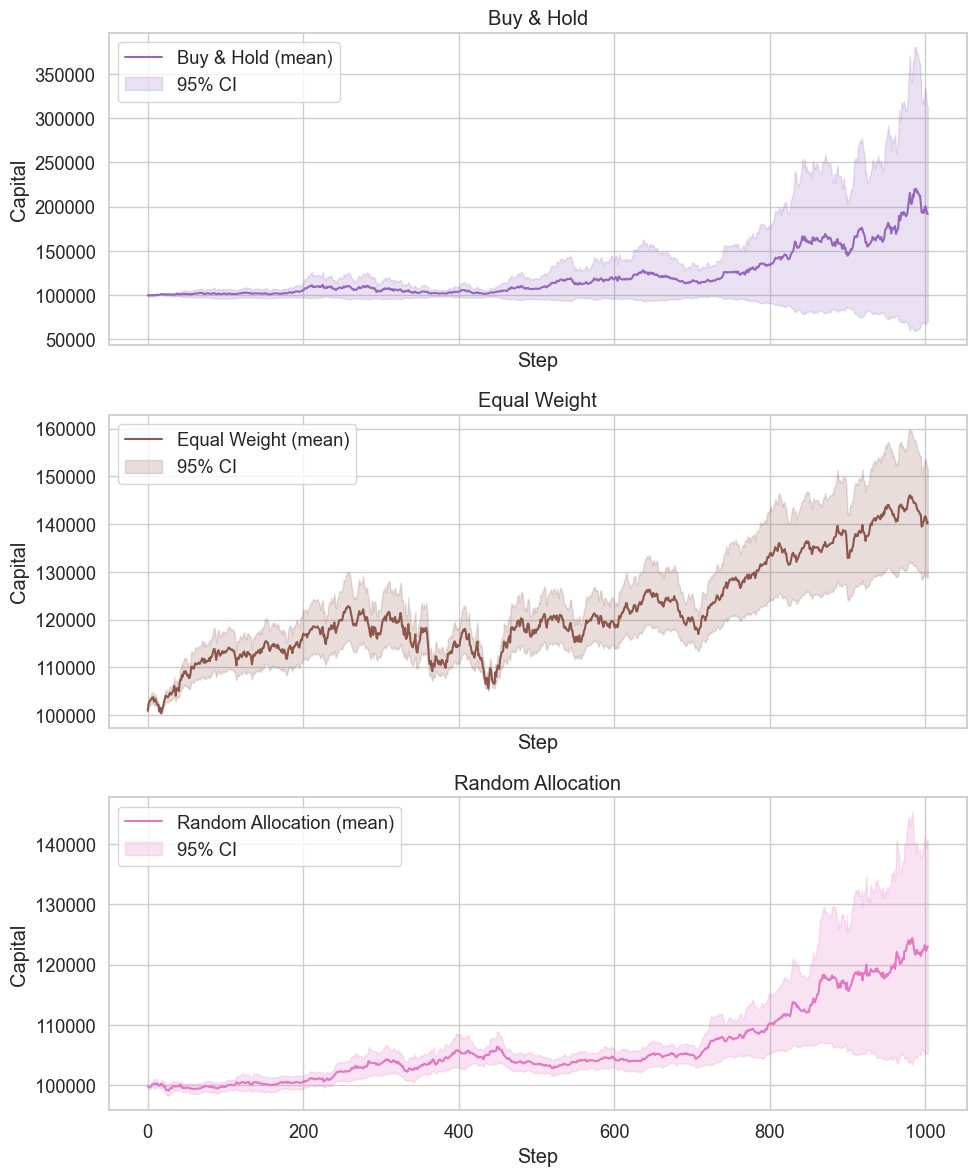

In [29]:
import numpy as np

def plot_benchmarks_with_ci(datasets, metric="capital", x="step", ci=0.95, save_path=None):
    """
    Plot one subplot per benchmark with mean and 95% confidence interval.
    
    Parameters
    ----------
    datasets : dict
        datasets["benchmarks"] from your data loading cell.
    metric : str
        The y-axis variable to plot (default: 'capital').
    x : str
        The x-axis variable (default: 'step').
    ci : float
        Confidence interval level (default: 0.95).
    save_path : str or None
        If provided, saves figure to this path instead of showing it.
    """
    benchmarks = datasets.get("benchmarks", {})
    n = len(benchmarks)
    if n == 0:
        print("⚠️ No benchmark data loaded.")
        return

    fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), sharex=True)
    if n == 1:
        axes = [axes]  # make iterable for 1 subplot

    for ax, (key, bm) in zip(axes, benchmarks.items()):
        df = bm
        if df is None:
            print(f"⚠️ Skipping {key} (no data).")
            continue
        
        label = BENCHMARKS[key]["label"]
        color = BENCHMARKS[key]["color"]

        # ensure sorting by x-axis variable
        df = df.sort_values(by=x)

        # compute mean and CI across seeds if available
        if "seed" in df.columns:
            grouped = df.groupby(x)[metric]
            mean = grouped.mean()
            std = grouped.std()
            n_obs = grouped.count()
            stderr = std / np.sqrt(n_obs)
            ci95 = 1.96 * stderr
            lower = mean - ci95
            upper = mean + ci95
            ax.plot(mean.index, mean, label=f"{label} (mean)", color=color)
            ax.fill_between(mean.index, lower, upper, color=color, alpha=0.2, label="95% CI")
        else:
            # fallback if only one run
            ax.plot(df[x], df[metric], label=label, color=color, linewidth=1.8)
            ax.fill_between(df[x], df[metric]*0.99, df[metric]*1.01, color=color, alpha=0.1, label="±1%")

        ax.set_title(f"{label}")
        ax.set_xlabel(x.capitalize())
        ax.set_ylabel(metric.capitalize())
        ax.legend(loc="best")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved: {save_path}")
        plt.close()
    else:
        plt.show()

plot_benchmarks_with_ci(datasets)


📊 Plotting RL models...
📊 Plotting benchmarks...


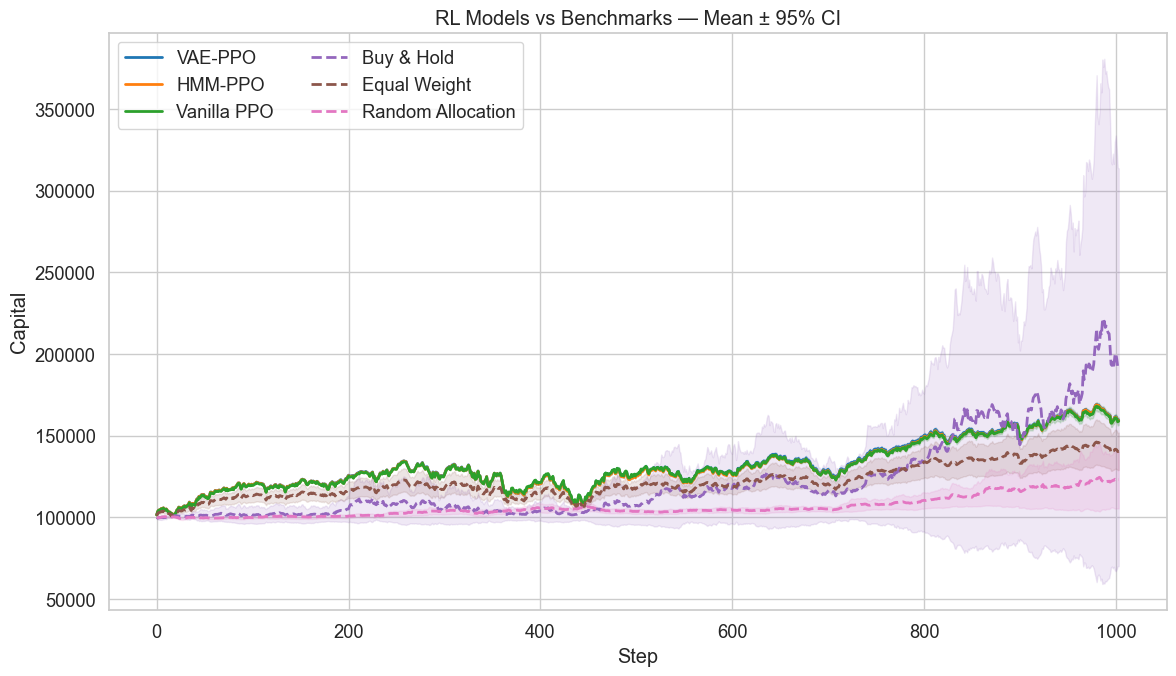

In [30]:
import numpy as np
from matplotlib.ticker import ScalarFormatter

def plot_all_models_and_benchmarks(datasets, metric="capital", x="step", ci=0.95, save_path=None):
    """
    Overlay all RL models and benchmarks with mean ± 95% CI bands.

    Parameters
    ----------
    datasets : dict
        Full datasets dictionary from Cell 1.
    metric : str
        Variable to plot on y-axis (default 'capital').
    x : str
        Variable to plot on x-axis (default 'step').
    ci : float
        Confidence interval level (default 0.95).
    save_path : str or None
        Path to save figure, or display interactively if None.
    """

    plt.figure(figsize=(12, 7))

    def plot_group(data_dict, meta_dict, linestyle="-", alpha=0.25):
        """Internal helper: plots one group (RL models or benchmarks)."""
        for key, df in data_dict.items():
            if df is None:
                continue
            label = meta_dict[key]["label"]
            color = meta_dict[key]["color"]

            df = df.sort_values(by=x)

            if "seed" in df.columns:
                grouped = df.groupby(x)[metric]
                mean = grouped.mean()
                std = grouped.std()
                n = grouped.count()
                stderr = std / np.sqrt(n)
                ci95 = 1.96 * stderr
                lower, upper = mean - ci95, mean + ci95

                plt.plot(mean.index, mean, label=label, color=color, linewidth=2, linestyle=linestyle)
                plt.fill_between(mean.index, lower, upper, color=color, alpha=alpha)
            else:
                plt.plot(df[x], df[metric], label=label, color=color, linewidth=2, linestyle=linestyle)
                plt.fill_between(df[x], df[metric]*0.99, df[metric]*1.01, color=color, alpha=alpha)

    # ---- RL MODELS ----
    print("📊 Plotting RL models...")
    plot_group(datasets["backtest"], EXPERIMENTS, linestyle="-", alpha=0.2)

    # ---- BENCHMARKS ----
    print("📊 Plotting benchmarks...")
    plot_group(datasets["benchmarks"], BENCHMARKS, linestyle="--", alpha=0.15)

    # ---- Formatting ----
    plt.title("RL Models vs Benchmarks — Mean ± 95% CI")
    plt.xlabel(x.capitalize())
    plt.ylabel(metric.capitalize())

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(style="plain", axis="y")
    ax.tick_params(axis="y", labelrotation=0)

    plt.legend(loc="best", ncol=2)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved: {save_path}")
        plt.close()
    else:
        plt.show()


plot_all_models_and_benchmarks(datasets)

📊 Plotting benchmarks only...


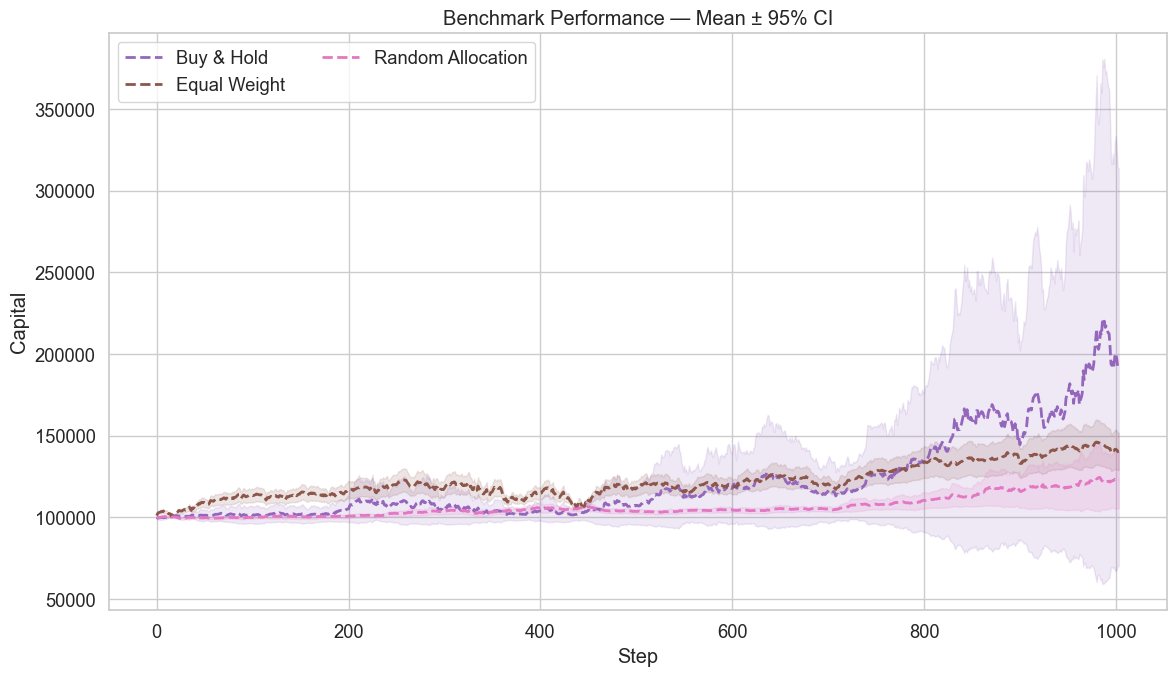

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def plot_benchmarks_only(datasets, metric="capital", x="step", ci=0.95, save_path=None):
    """
    Plot only benchmark results with mean ± 95% CI bands.

    Parameters
    ----------
    datasets : dict
        Full datasets dictionary from Cell 1.
    metric : str
        Variable to plot on y-axis (default 'capital').
    x : str
        Variable to plot on x-axis (default 'step').
    ci : float
        Confidence interval level (default 0.95).
    save_path : str or None
        Path to save figure, or display interactively if None.
    """

    plt.close()  # ensure clean start
    plt.figure(figsize=(12, 7))

    def plot_group(data_dict, meta_dict, linestyle="--", alpha=0.15):
        """Internal helper: plots only the benchmarks."""
        for key, df in data_dict.items():
            if df is None:
                continue
            label = meta_dict[key]["label"]
            color = meta_dict[key]["color"]

            df = df.sort_values(by=x)

            if "seed" in df.columns:
                grouped = df.groupby(x)[metric]
                mean = grouped.mean()
                std = grouped.std()
                n = grouped.count()
                stderr = std / np.sqrt(n)
                ci95 = 1.96 * stderr
                lower, upper = mean - ci95, mean + ci95

                plt.plot(mean.index, mean, label=label, color=color, linewidth=2, linestyle=linestyle)
                plt.fill_between(mean.index, lower, upper, color=color, alpha=alpha)
            else:
                plt.plot(df[x], df[metric], label=label, color=color, linewidth=2, linestyle=linestyle)
                plt.fill_between(df[x], df[metric]*0.99, df[metric]*1.01, color=color, alpha=alpha)

    # ---- BENCHMARKS ONLY ----
    print("📊 Plotting benchmarks only...")
    plot_group(datasets["benchmarks"], BENCHMARKS, linestyle="--", alpha=0.15)

    # ---- Formatting ----
    plt.title("Benchmark Performance — Mean ± 95% CI")
    plt.xlabel(x.capitalize())
    plt.ylabel(metric.capitalize())

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(style="plain", axis="y")
    ax.tick_params(axis="y", labelrotation=0)

    plt.legend(loc="best", ncol=2)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved: {save_path}")
        plt.close()
    else:
        plt.show()

plot_benchmarks_only(dataseimport numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def plot_rl_models_only(datasets, metric="capital", x="step", ci=0.95, save_path=None):
    """
    Plot only RL model results with mean ± 95% CI bands.

    Parameters
    ----------
    datasets : dict
        Full datasets dictionary from Cell 1.
    metric : str
        Variable to plot on y-axis (default 'capital').
    x : str
        Variable to plot on x-axis (default 'step').
    ci : float
        Confidence interval level (default 0.95).
    save_path : str or None
        Path to save figure, or display interactively if None.
    """

    plt.close()  # clear any existing figures
    plt.figure(figsize=(12, 7))

    def plot_group(data_dict, meta_dict, linestyle="-", alpha=0.25):
        """Internal helper: plots one group (RL models)."""
        for key, df in data_dict.items():
            if df is None:
                continue
            label = meta_dict[key]["label"]
            color = meta_dict[key]["color"]

            df = df.sort_values(by=x)

            if "seed" in df.columns:
                grouped = df.groupby(x)[metric]
                mean = grouped.mean()
                std = grouped.std()
                n = grouped.count()
                stderr = std / np.sqrt(n)
                ci95 = 1.96 * stderr
                lower, upper = mean - ci95, mean + ci95

                plt.plot(mean.index, mean, label=label, color=color, linewidth=2, linestyle=linestyle)
                plt.fill_between(mean.index, lower, upper, color=color, alpha=alpha)
            else:
                plt.plot(df[x], df[metric], label=label, color=color, linewidth=2, linestyle=linestyle)
                plt.fill_between(df[x], df[metric]*0.99, df[metric]*1.01, color=color, alpha=alpha)

    # ---- RL MODELS ONLY ----
    print("🤖 Plotting RL strategies only...")
    plot_group(datasets["backtest"], EXPERIMENTS, linestyle="-", alpha=0.2)

    # ---- Formatting ----
    plt.title("RL Strategies — Mean ± 95% CI")
    plt.xlabel(x.capitalize())
    plt.ylabel(metric.capitalize())

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(style="plain", axis="y")
    ax.tick_params(axis="y", labelrotation=0)

    plt.legend(loc="best", ncol=2)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved: {save_path}")
        plt.close()
    else:
        plt.show()
ts)


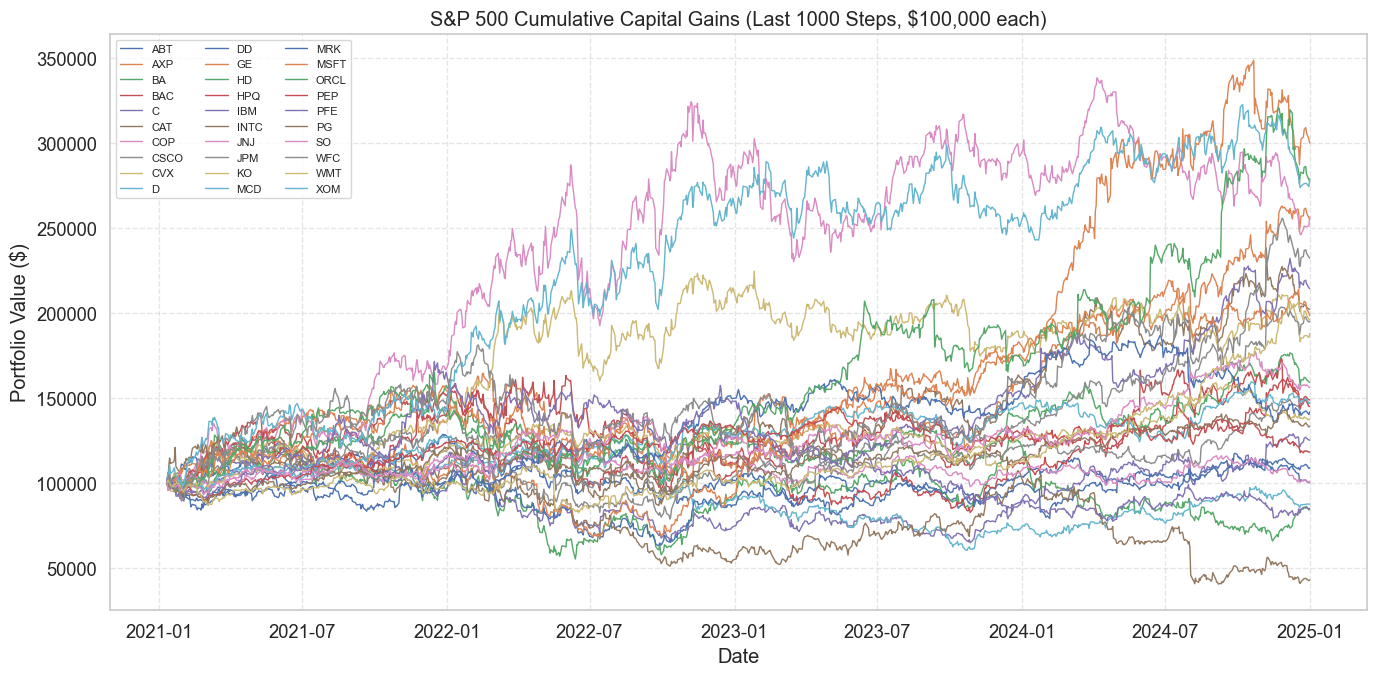


Final portfolio values (sorted):
ticker
GE     $300,169.25
XOM    $279,267.99
ORCL   $278,039.71
COP    $256,739.30
AXP    $255,581.12
WFC    $232,407.00
IBM    $214,500.36
CAT    $202,309.84
MSFT   $198,550.40
WMT    $195,975.17
JPM    $195,091.98
CVX    $187,964.63
HD     $159,309.05
SO     $156,308.68
BAC    $148,998.48
CSCO   $147,238.14
MCD    $147,100.29
HPQ    $145,062.61
MRK    $141,832.14
KO     $137,612.00
PG     $133,367.70
C      $125,255.63
PEP    $118,321.79
ABT    $108,860.52
JNJ    $101,062.78
DD     $100,458.34
D       $87,495.98
PFE     $85,035.38
BA      $84,325.87
INTC    $42,940.13


In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from environments.data import PortfolioDataset

def plot_sp500_cumulative_gains(last_n=1000, initial_investment=100_000):
    # Load SP500 dataset
    dataset = PortfolioDataset(asset_class="sp500")
    df = dataset.full_data.copy()

    # Prepare data
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['date', 'ticker'])

    # Ensure returns exist
    if 'returns' not in df.columns:
        df['returns'] = df.groupby('ticker')['close'].pct_change()

    # Select last N time steps
    unique_dates = sorted(df['date'].unique())
    selected_dates = unique_dates[-last_n:]
    df_recent = df[df['date'].isin(selected_dates)]

    # Pivot to get time series per ticker
    pivot_df = df_recent.pivot(index='date', columns='ticker', values='returns')

    # Compute cumulative capital for each ticker
    cum_capital = (1 + pivot_df.fillna(0)).cumprod() * initial_investment

    # Plot cumulative capital
    plt.figure(figsize=(14, 7))
    for ticker in cum_capital.columns:
        plt.plot(cum_capital.index, cum_capital[ticker], label=ticker, linewidth=1)

    plt.title(f"S&P 500 Cumulative Capital Gains (Last {last_n} Steps, ${initial_investment:,.0f} each)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend(loc='upper left', fontsize=8, ncol=3)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Optionally, return final capital per ticker
    final_values = cum_capital.iloc[-1].sort_values(ascending=False)
    print("\nFinal portfolio values (sorted):")
    print(final_values.to_string(float_format=lambda x: f"${x:,.2f}"))

if __name__ == "__main__":
    plot_sp500_cumulative_gains(last_n=1000, initial_investment=100_000)


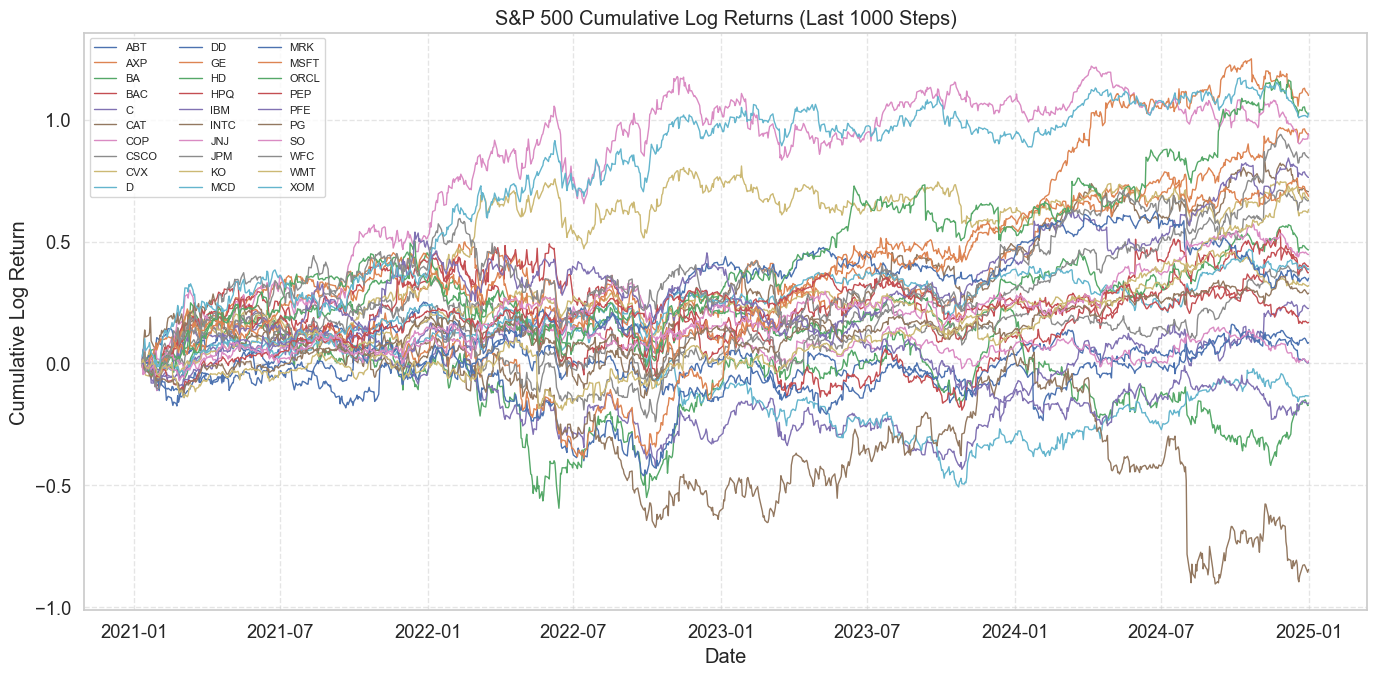


Final cumulative log-returns (sorted):
ticker
GE      1.0992
XOM     1.0270
ORCL    1.0226
COP     0.9429
AXP     0.9384
WFC     0.8433
IBM     0.7631
CAT     0.7046
MSFT    0.6859
WMT     0.6728
JPM     0.6683
CVX     0.6311
HD      0.4657
SO      0.4467
BAC     0.3988
CSCO    0.3869
MCD     0.3859
HPQ     0.3720
MRK     0.3495
KO      0.3193
PG      0.2879
C       0.2252
PEP     0.1682
ABT     0.0849
JNJ     0.0106
DD      0.0046
D      -0.1336
PFE    -0.1621
BA     -0.1705
INTC   -0.8454


In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from environments.data import PortfolioDataset

def plot_sp500_cumulative_log_returns(last_n=1000):
    """
    Plot cumulative log returns of each S&P 500 constituent
    over the last N time steps.
    """
    # Load SP500 dataset
    dataset = PortfolioDataset(asset_class="sp500")
    df = dataset.full_data.copy()

    # Ensure chronological order
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["date", "ticker"])

    # Compute simple returns if not available
    if "returns" not in df.columns:
        df["returns"] = df.groupby("ticker")["close"].pct_change()

    # Select last N unique dates
    unique_dates = sorted(df["date"].unique())
    selected_dates = unique_dates[-last_n:]
    df_recent = df[df["date"].isin(selected_dates)]

    # Pivot to wide format: date × ticker
    pivot_df = df_recent.pivot(index="date", columns="ticker", values="returns").fillna(0)

    # Compute cumulative log returns
    log_returns = np.log1p(pivot_df)  # log(1 + r)
    cum_log_returns = log_returns.cumsum()

    # Plot
    plt.figure(figsize=(14, 7))
    for ticker in cum_log_returns.columns:
        plt.plot(cum_log_returns.index, cum_log_returns[ticker], label=ticker, linewidth=1)

    plt.title(f"S&P 500 Cumulative Log Returns (Last {last_n} Steps)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Log Return")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc="upper left", fontsize=8, ncol=3)
    plt.tight_layout()
    plt.show()

    # Optionally return final cumulative log-returns
    final_vals = cum_log_returns.iloc[-1].sort_values(ascending=False)
    print("\nFinal cumulative log-returns (sorted):")
    print(final_vals.to_string(float_format=lambda x: f"{x:.4f}"))

if __name__ == "__main__":
    plot_sp500_cumulative_log_returns(last_n=1000)


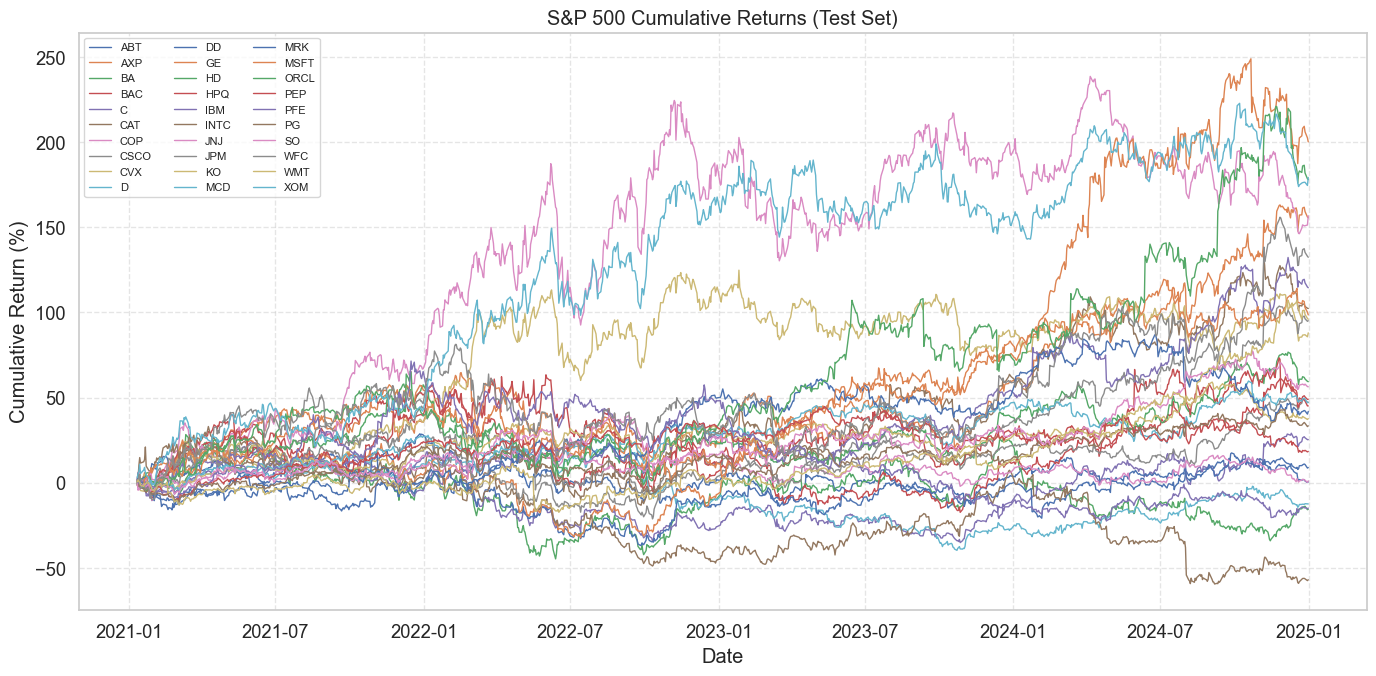


Final cumulative returns (sorted):
ticker
GE     200.17%
XOM    179.27%
ORCL   178.04%
COP    156.74%
AXP    155.58%
WFC    132.41%
IBM    114.50%
CAT    102.31%
MSFT    98.55%
WMT     95.98%
JPM     95.09%
CVX     87.96%
HD      59.31%
SO      56.31%
BAC     49.00%
CSCO    47.24%
MCD     47.10%
HPQ     45.06%
MRK     41.83%
KO      37.61%
PG      33.37%
C       25.26%
PEP     18.32%
ABT      8.86%
JNJ      1.06%
DD       0.46%
D      -12.50%
PFE    -14.96%
BA     -15.67%
INTC   -57.06%


In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from environments.data import PortfolioDataset

def plot_sp500_cumulative_returns(last_n=1000):
    """
    Plot cumulative percentage returns of each S&P 500 constituent
    over the last N time steps.
    """
    # Load SP500 dataset
    dataset = PortfolioDataset(asset_class="sp500")
    df = dataset.full_data.copy()

    # Prepare and sort data
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["date", "ticker"])

    # Compute simple returns if missing
    if "returns" not in df.columns:
        df["returns"] = df.groupby("ticker")["close"].pct_change()

    # Select last N unique dates
    unique_dates = sorted(df["date"].unique())
    selected_dates = unique_dates[-last_n:]
    df_recent = df[df["date"].isin(selected_dates)]

    # Pivot into matrix: date × ticker
    pivot_df = df_recent.pivot(index="date", columns="ticker", values="returns").fillna(0)

    # Compute cumulative returns (in percentage, not dollars)
    cum_returns = (1 + pivot_df).cumprod() - 1

    # Plot
    plt.figure(figsize=(14, 7))
    for ticker in cum_returns.columns:
        plt.plot(cum_returns.index, cum_returns[ticker] * 100, label=ticker, linewidth=1)

    plt.title(f"S&P 500 Cumulative Returns (Test Set)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (%)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc="upper left", fontsize=8, ncol=3)
    plt.tight_layout()
    plt.show()

    # Print summary of last values
    final_vals = cum_returns.iloc[-1].sort_values(ascending=False)
    print("\nFinal cumulative returns (sorted):")
    print(final_vals.to_string(float_format=lambda x: f"{x*100:.2f}%"))

if __name__ == "__main__":
    plot_sp500_cumulative_returns(last_n=1000)


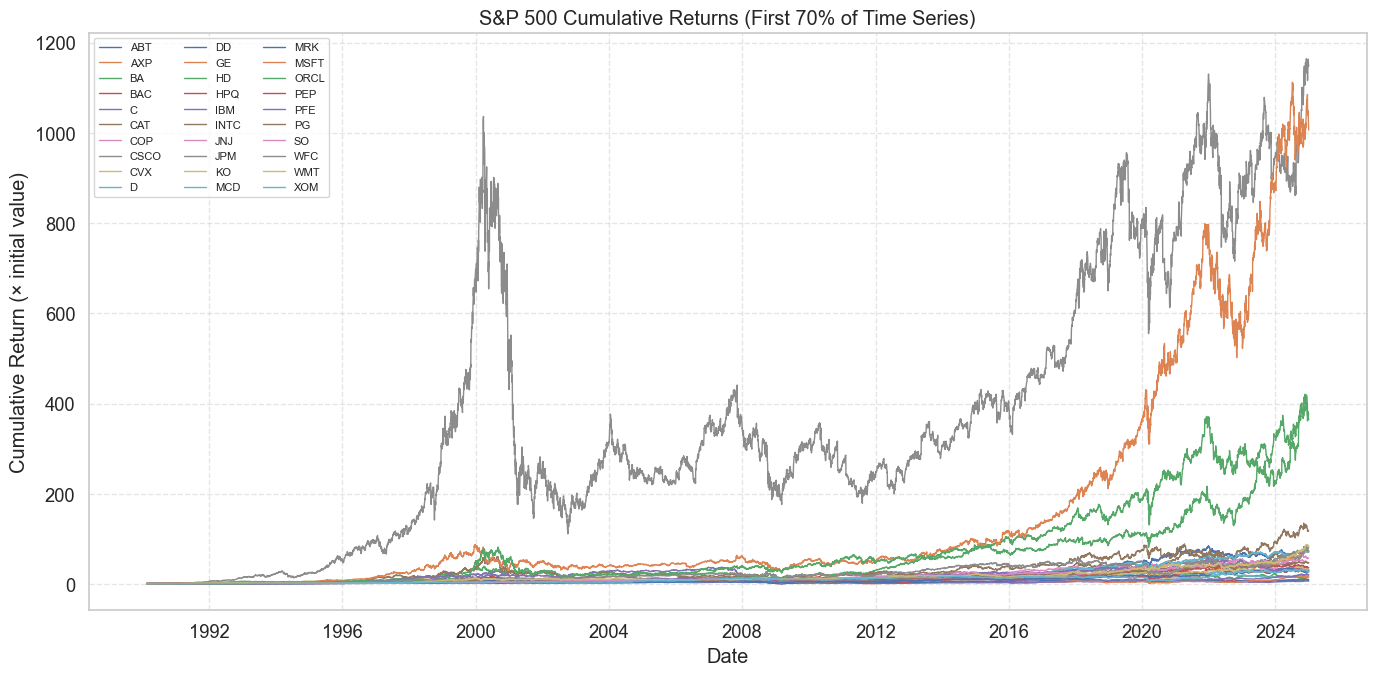


Final cumulative returns (first 70% period):
ticker
CSCO   1148.34×
MSFT   1006.47×
HD      375.12×
ORCL    364.41×
CAT     117.72×
WMT      83.13×
JPM      80.56×
WFC      74.42×
AXP      72.06×
ABT      71.48×
MCD      71.17×
SO       56.97×
JNJ      47.29×
PG       46.93×
PEP      36.60×
KO       33.46×
HPQ      31.45×
COP      30.68×
CVX      30.23×
PFE      29.64×
INTC     28.77×
XOM      28.62×
MRK      27.04×
IBM      21.02×
D        19.04×
GE       15.76×
BA       15.60×
BAC      10.38×
DD        8.32×
C         6.78×


In [34]:
import matplotlib.pyplot as plt
import pandas as pd
from environments.data import PortfolioDataset

def plot_sp500_cumulative_returns_first70():
    # Load SP500 dataset
    dataset = PortfolioDataset(asset_class="sp500")
    df = dataset.full_data.copy()

    # Prepare data
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['date', 'ticker'])

    # Ensure returns exist
    if 'returns' not in df.columns:
        df['returns'] = df.groupby('ticker')['close'].pct_change()

    # --- Select first 70% of the time series ---
    unique_dates = sorted(df['date'].unique())
    cutoff_idx = int(len(unique_dates))
    selected_dates = unique_dates[:cutoff_idx]
    df_subset = df[df['date'].isin(selected_dates)]

    # Pivot to wide format
    pivot_df = df_subset.pivot(index='date', columns='ticker', values='returns')

    # Compute cumulative returns (normalized, start = 1)
    cum_returns = (1 + pivot_df.fillna(0)).cumprod()

    # --- Plot cumulative returns ---
    plt.figure(figsize=(14, 7))
    for ticker in cum_returns.columns:
        plt.plot(cum_returns.index, cum_returns[ticker], label=ticker, linewidth=1)

    plt.title("S&P 500 Cumulative Returns (First 70% of Time Series)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (× initial value)")
    plt.legend(loc='upper left', fontsize=8, ncol=3)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Print final cumulative returns
    final_returns = cum_returns.iloc[-1].sort_values(ascending=False)
    print("\nFinal cumulative returns (first 70% period):")
    print(final_returns.to_string(float_format=lambda x: f"{x:.2f}×"))

if __name__ == "__main__":
    plot_sp500_cumulative_returns_first70()



🏆 Top 5 performers (first 70% of time series):
ticker
CSCO   1148.34×
MSFT   1006.47×
HD      375.12×
ORCL    364.41×
CAT     117.72×


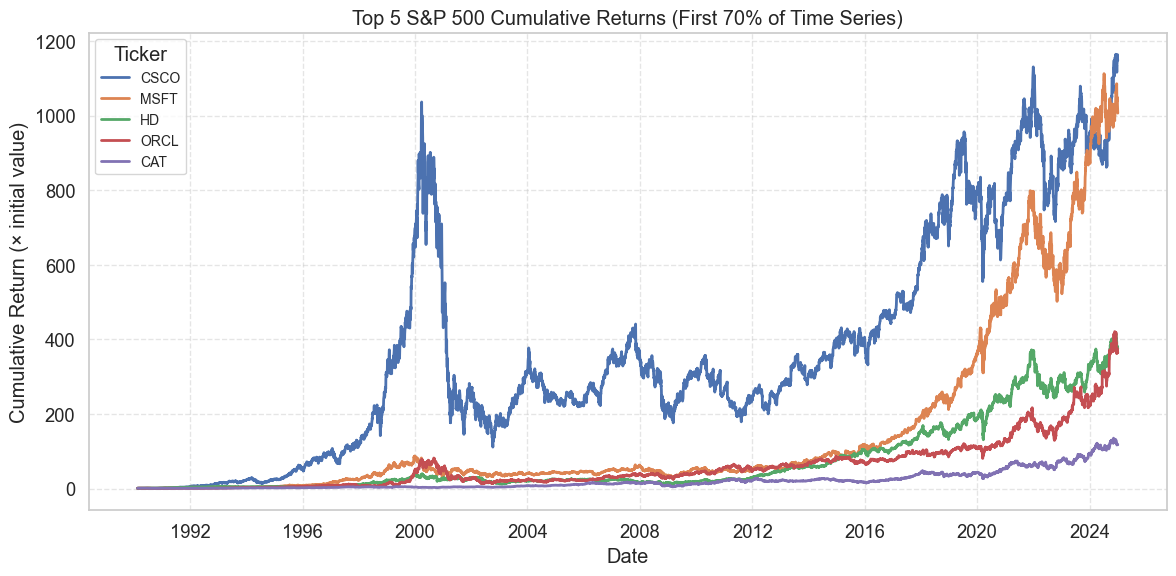

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from environments.data import PortfolioDataset

def plot_sp500_top5_cumulative_returns_first70():
    # Load SP500 dataset
    dataset = PortfolioDataset(asset_class="sp500")
    df = dataset.full_data.copy()

    # Prepare data
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['date', 'ticker'])

    # Ensure returns exist
    if 'returns' not in df.columns:
        df['returns'] = df.groupby('ticker')['close'].pct_change()

    # --- Select first 70% of the time series ---
    unique_dates = sorted(df['date'].unique())
    cutoff_idx = int(len(unique_dates))
    selected_dates = unique_dates[:cutoff_idx]
    df_subset = df[df['date'].isin(selected_dates)]

    # Pivot to wide format
    pivot_df = df_subset.pivot(index='date', columns='ticker', values='returns')

    # Compute cumulative returns (normalized, start = 1)
    cum_returns = (1 + pivot_df.fillna(0)).cumprod()

    # --- Identify top 5 performers at the end ---
    final_values = cum_returns.iloc[-1].sort_values(ascending=False)
    top5_tickers = final_values.head(5).index.tolist()

    # Print top 5
    print("\n🏆 Top 5 performers (first 70% of time series):")
    print(final_values.head(5).to_string(float_format=lambda x: f"{x:.2f}×"))

    # --- Plot top 5 cumulative returns ---
    plt.figure(figsize=(12, 6))
    for ticker in top5_tickers:
        plt.plot(cum_returns.index, cum_returns[ticker], label=ticker, linewidth=2)

    plt.title("Top 5 S&P 500 Cumulative Returns (First 70% of Time Series)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (× initial value)")
    plt.legend(title="Ticker", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_sp500_top5_cumulative_returns_first70()
